In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import json
import math
import operator

%matplotlib inline

# DATASETS

In [2]:
from os import listdir
from os.path import isfile, join
folder = "datasets"
dataset_list = [join(folder, f) for f in listdir(folder) if isfile(join(folder, f)) and 'csv' in join(folder, f)]

In [3]:
def generate_chart(AUC, xticklabels, yticklabels, height=10):

    def show_values(pc, fmt="%.2f", **kw):
        '''
        Heatmap with text in each cell with matplotlib's pyplot
        Source: http://stackoverflow.com/a/25074150/395857 
        By HYRY
        '''
        from itertools import izip
        pc.update_scalarmappable()
        ax = pc.get_axes()
        max_value = max(1.0, max(pc.get_array()))
        for p, color, value in izip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[:3] > max_value/2.0):
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

    # Plot it out
    fig, ax = plt.subplots() 
    
    max_value = max(1.0, max([item for sublist in AUC for item in sublist]))
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=max_value)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    plt.xticks(rotation=90)

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(20, height)

/Users/robson/Documents/git/env/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


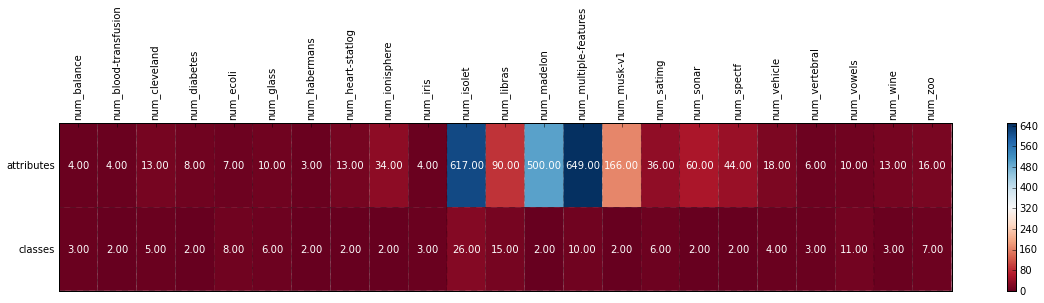

In [4]:
xticklabels_ds = [ds.replace(".csv", "").split("/")[-1] for ds in dataset_list]
yticklabels_ds = ['attributes', 'classes']
att_list = []
classes_list = []
for dataset in dataset_list:
    pd_ds = pd.read_csv(dataset)    
    attributes_and_class = list(pd_ds.columns.values)
    y_str = pd_ds[attributes_and_class[-1]].values
    labels = list(set([label for label in y_str]))

    att_list.append(len(attributes_and_class)-1)
    classes_list.append(len(labels))

AUC_ds = np.array([att_list, classes_list])
generate_chart(AUC_ds, xticklabels_ds, yticklabels_ds, height=3)

# CLASSIFIERS

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import tensorflow.contrib.learn.python.learn as learn
import tensorflow as tf

classifiers_names = [
         "Nearest Neighbors",
         "Linear SVM",
         "RBF SVM",
         "Decision Tree",
         "Random Forest",
         "AdaBoost",
         "Naive Bayes",
         "DNNClassifier-10-20-10",
         "DNNClassifier-30-100-30",
]

# CLASSIFIERS: INTERPRETATION

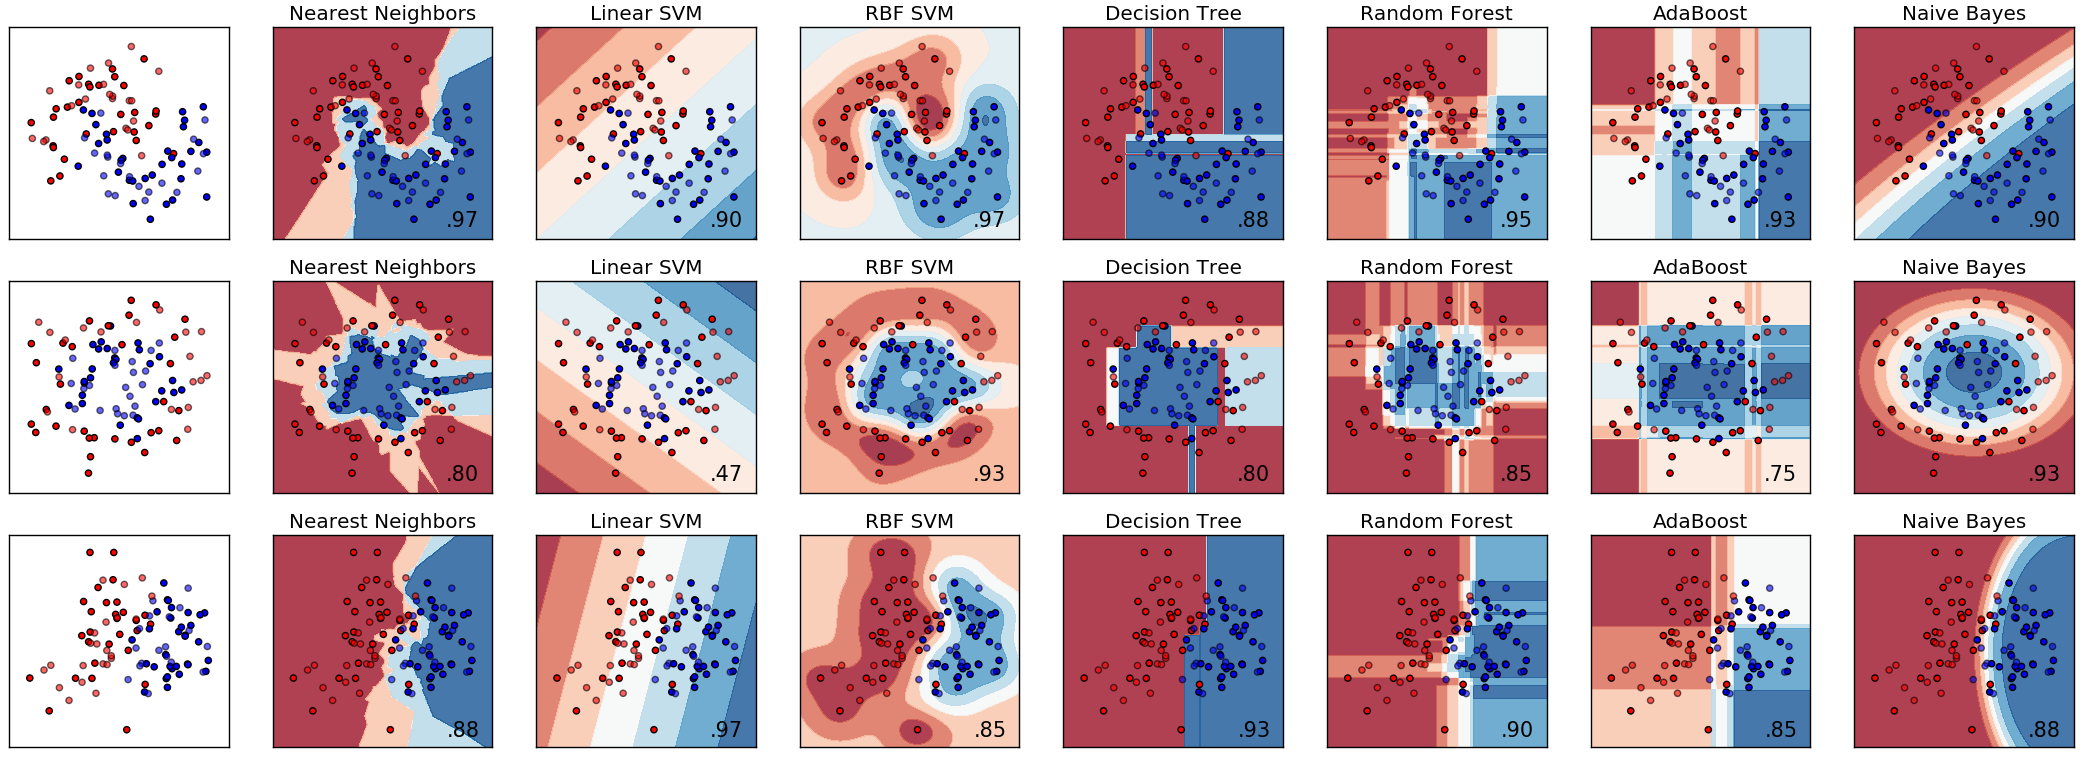

In [6]:
from IPython.display import Image
Image(filename='comparison_classifiers.png')

In [7]:
import webbrowser
url = 'http://playground.tensorflow.org/'
webbrowser.open(url)

# DL starts with:
# - speech recognition
# - computer vision: AlexNet, which achieved an error rate of 15% (40% better than state of the art).
# - machine translation

# thanks to:
# - data
# - gpu
# - research

True

# RUN: ALL CLASSIFIERS AND ALL DATASETS

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    
def classify_dataset(Xy_list, n_fold=10, evaluation=accuracy_score):
    results_per_clf_dataset_fold = {}
    for X, y, dataset, n_attributes, n_labels in Xy_list:
        print dataset
        X = np.array(X)
        y = np.array(y)
        skf = StratifiedKFold(y, n_fold)
        fold = 0
        for train_index, test_index in skf:
            fold += 1
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            for clf_name in classifiers_names:
                if clf_name == "Nearest Neighbors":
                    clf = KNeighborsClassifier()
                    clf.fit(X_train, y_train)
                if clf_name == "Linear SVM":
                    clf = SVC(kernel="linear", C=0.025)
                    clf.fit(X_train, y_train)
                if clf_name == "RBF SVM":
                    clf = SVC(gamma=2, C=1)
                    clf.fit(X_train, y_train)
                if clf_name == "Decision Tree":
                    clf = DecisionTreeClassifier(max_depth=5)
                    clf.fit(X_train, y_train)
                if clf_name == "Random Forest":
                    clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
                    clf.fit(X_train, y_train)
                if clf_name == "AdaBoost":
                    clf = AdaBoostClassifier()
                    clf.fit(X_train, y_train)
                if clf_name == "Naive Bayes":
                    clf = GaussianNB()
                    clf.fit(X_train, y_train)
                if clf_name == "DNNClassifier-10-20-10":
                    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=n_attributes)]
                    clf = learn.DNNClassifier(hidden_units=[10, 20, 10], n_classes=n_labels, feature_columns=feature_columns)
                    clf.fit(X_train, y_train, steps=200, batch_size=32)
                if clf_name == "DNNClassifier-30-100-30":
                    feature_columns = [tf.contrib.layers.real_valued_column("", dimension=n_attributes)]
                    clf = learn.DNNClassifier(hidden_units=[30, 100, 30], n_classes=n_labels, feature_columns=feature_columns)
                    clf.fit(X_train, y_train, steps=200, batch_size=32)

                y_predicted = clf.predict(X_test)

                evaluation_score = evaluation(y_test, y_predicted)
                results_per_clf_dataset_fold.setdefault(clf_name, {})
                results_per_clf_dataset_fold[clf_name].setdefault(dataset, [])
                results_per_clf_dataset_fold[clf_name][dataset].append(evaluation_score)

    results_per_clf = {}
    for clf_name in results_per_clf_dataset_fold:
        results_per_clf.setdefault(clf_name, [])
        for dataset in results_per_clf_dataset_fold[clf_name]:
            average_accuracy = sum(results_per_clf_dataset_fold[clf_name][dataset]) / float(len(results_per_clf_dataset_fold[clf_name][dataset]))
            results_per_clf[clf_name].append(average_accuracy)

    return results_per_clf

In [9]:
Xy_list = []
for dataset in dataset_list:
    pd_ds = pd.read_csv(dataset)

    attributes_and_class = list(pd_ds.columns.values)
    X = pd_ds[attributes_and_class[:-1]].values
    y_str = pd_ds[attributes_and_class[-1]].values
    labels = list(set([label for label in y_str]))
    y = [labels.index(item) for item in y_str]
    X = pd.DataFrame(StandardScaler().fit_transform(X))
    n_atributes = len(attributes_and_class)-1
    n_labels = len(labels)
    Xy_list.append([X, y, dataset, n_atributes, n_labels])

results_per_clf, _ = classify_dataset(Xy_list)

/Users/robson/Documents/git/env/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/robson/Documents/git/env/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/robson/Documents/git/env/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/robson/Documents/git/env/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/robson/Documents/git/env/lib/python2.7/site-packages/sklearn/util

datasets/num_balance.csv


datasets/num_blood-transfusion.csv


datasets/num_cleveland.csv


datasets/num_diabetes.csv


datasets/num_ecoli.csv


/Users/robson/Documents/git/env/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/Users/robson/Documents/git/env/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


datasets/num_glass.csv


datasets/num_habermans.csv


datasets/num_heart-statlog.csv


datasets/num_ionisphere.csv


datasets/num_iris.csv


datasets/num_isolet.csv


datasets/num_libras.csv


datasets/num_madelon.csv


datasets/num_multiple-features.csv


datasets/num_musk-v1.csv


datasets/num_satimg.csv


datasets/num_sonar.csv


datasets/num_spectf.csv


datasets/num_vehicle.csv


datasets/num_vertebral.csv


datasets/num_vowels.csv


datasets/num_wine.csv


datasets/num_zoo.csv


/Users/robson/Documents/git/env/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


# RANK: CLASSIFIER PER DATASET

# CHART: VISUAL COMPARISON

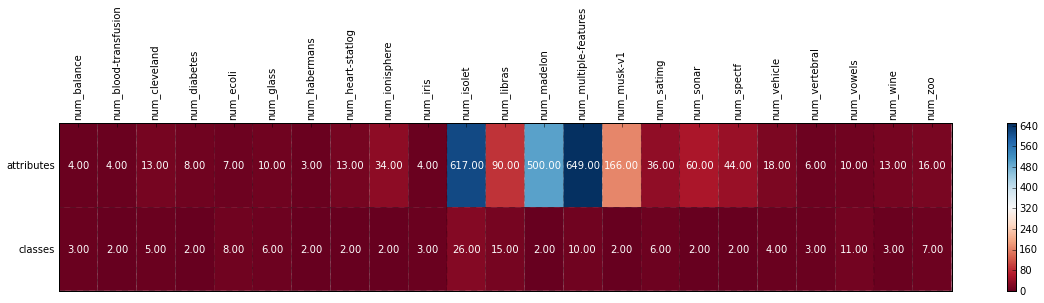

In [10]:
generate_chart(AUC_ds, xticklabels_ds, yticklabels_ds, height=3)

In [11]:
def get_position_by_clf_and_sorted_clf(dataset_name_list, results_per_clf):
    position_by_clf = {}
    for dataset_id in range(len(dataset_name_list)):
        current_comparation = {clf_name: values_array[dataset_id] for clf_name, values_array in results_per_clf.items()}
        rank = {key: rank for rank, key in enumerate(sorted(set(current_comparation.values()), reverse=True), 1)}
        clf_rank = {k: rank[v] for k,v in current_comparation.items()}
        for clf_name in clf_rank:
            position_by_clf.setdefault(clf_name, 0)
            position_by_clf[clf_name] += clf_rank[clf_name]
    sorted_clf = [clf for clf, score in sorted(position_by_clf.items(), key=operator.itemgetter(1))]
    return position_by_clf, sorted_clf


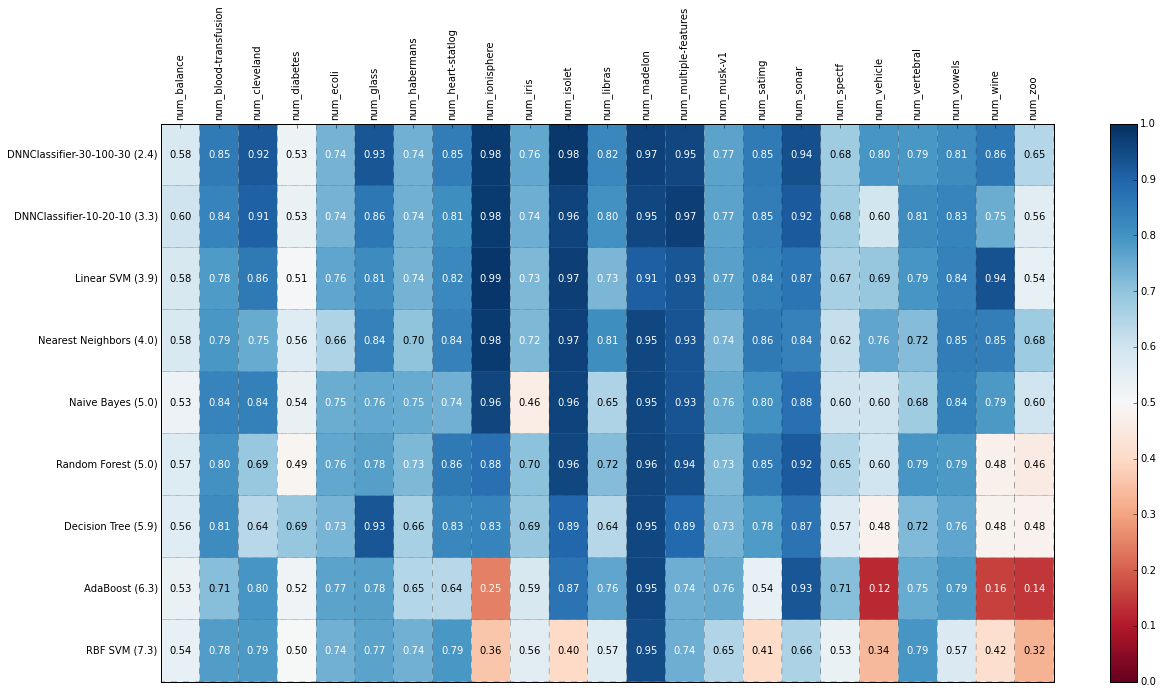

In [14]:
position_by_clf, sorted_clf = get_position_by_clf_and_sorted_clf(dataset_list, results_per_clf)

xticklabels = [ds.replace(".csv", "").split("/")[-1] for ds in dataset_list]
yticklabels = [clf+" ("+str(round(position_by_clf[clf]/float(len(dataset_list)), 1))+")" for clf in sorted_clf]
AUC = np.array([results_per_clf[clf_name] for clf_name in sorted_clf])

generate_chart(AUC, xticklabels, yticklabels)